In [101]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import tensorflow as tf
import tensorflow.contrib.slim as slim


import math

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.examples.tutorials.mnist import input_data

cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)

#torch.manual_seed(42)
#if cuda:
#    torch.cuda.manual_seed(42)

Using PyTorch version: 0.4.1.post2 CUDA: False


In [87]:
batch_size = 32

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

validation_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=False, **kwargs)

In [88]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


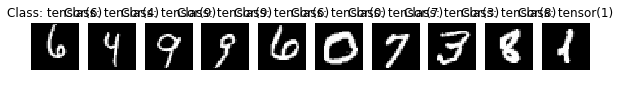

In [89]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray")
    plt.title('Class: '+str(y_train[i]))

In [90]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 128)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), 1)

model = Net()
if cuda:
    model.cuda()
    
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


print(model)



Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc1_drop): Dropout(p=0.2)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc2_drop): Dropout(p=0.2)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [91]:
def train(epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [92]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        val_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [93]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.251950
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.272796
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.978834
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.399526
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.573006
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.586279
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.669657
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.478197
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.380596
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.251704
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.366361
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.480957
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.221363
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.182270
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.248867
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.745333
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.137605
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.382545
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.403019

Validation set: Average loss: 0.2006, Accuracy: 9393/10000

Train Epoch: 9 [9600/60000 (16%)]	Loss: 0.055748
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.030685
Train Epoch: 9 [16000/60000 (27%)]	Loss: 0.015350
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.136771
Train Epoch: 9 [22400/60000 (37%)]	Loss: 0.059863
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.063505
Train Epoch: 9 [28800/60000 (48%)]	Loss: 0.098249
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.109917
Train Epoch: 9 [35200/60000 (59%)]	Loss: 0.017586
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.107423
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.007149
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.145542
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.043073
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.034006
Train Epoch: 9 [54400/60000 (91%)]	Loss: 0.023013
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.110353

Validation set: Average loss: 0.0751, Accuracy: 9782/10000 (97%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.096279
Train Epoch: 10 [3200/60000 (5%)]	Loss: 0.205089
Train Epoch: 10 [6400/60000 (11%)]	Loss

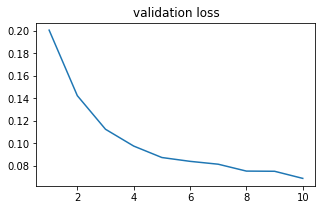

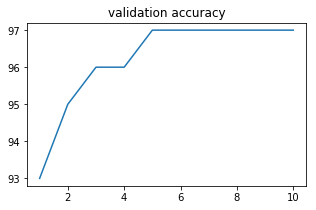

In [94]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

In [95]:
torch.save(model, 'myModel.pt')

/home/michela/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [96]:
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotNNFilter(units)

In [97]:
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")


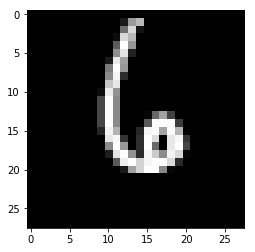

In [98]:
imageToUse = X_train[0]
plt.imshow(np.reshape(imageToUse,[28,28]), interpolation="nearest", cmap="gray")